In [9]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import seaborn as sns
import pandas as pd
from scipy.signal import butter,filtfilt
import matplotlib.pyplot as plt

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

from matplotlib import pylab as plt
%matplotlib inline
import scipy.stats


In [10]:
with open('../quint/data/sample_texts/joe_rogan_tr.txt') as f:
    doc = f.readlines()
doc = doc[0].replace("?", ". ")
sentences = doc.split('. ')

In [11]:
# from nltk.corpus import stopwords 
# import string
# from nltk.stem.wordnet import WordNetLemmatizer
# from nltk import word_tokenize 

# def clean (text):
#     for punctuation in string.punctuation:
#         text = text.replace(punctuation, ' ') # Remove Punctuation
#     lowercased = text.lower() # Lower Case
#     tokenized = word_tokenize(lowercased) # Tokenize
#     words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
#     stop_words = set(stopwords.words('english')) # Make stopword list
#     without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words
#     lemma=WordNetLemmatizer() # Initiate Lemmatizer
#     lemmatized = [lemma.lemmatize(word) for word in without_stopwords] # Lemmatize
#     return lemmatized


In [12]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

embeddings = model.encode(sentences)


/home/poloniki/.pyenv/versions/3.8.12/envs/quint/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
A =  embeddings
A_sparse = sparse.csr_matrix(A)
similarities = cosine_similarity(A_sparse)
#also can output sparse matrices
similarities_sparse = cosine_similarity(A_sparse,dense_output=False)

In [14]:
story = []

for each in range(embeddings.shape[0]):
    try:
        A =  embeddings[each:each+10]
        A_sparse = sparse.csr_matrix(A)
        similarities = cosine_similarity(A_sparse)
        story.append(similarities[1:,0].max())

    except:
        print('We reached an end')

We reached an end


In [15]:
# A =  embeddings[0:0+4]
# A_sparse = sparse.csr_matrix(A)
# similarities = cosine_similarity(A_sparse)
# sparse = cosine_similarity(A_sparse,dense_output=False)
# print('pairwise sparse output:\n {}\n'.format(sparse))

In [16]:
df = pd.DataFrame()
df['story'] = story
df['sentence'] = sentences[:-1]
df['len'] = df['sentence'].apply(lambda x: len(x))
df['cum'] = df['len'].cumsum()

<AxesSubplot:xlabel='cum', ylabel='story'>

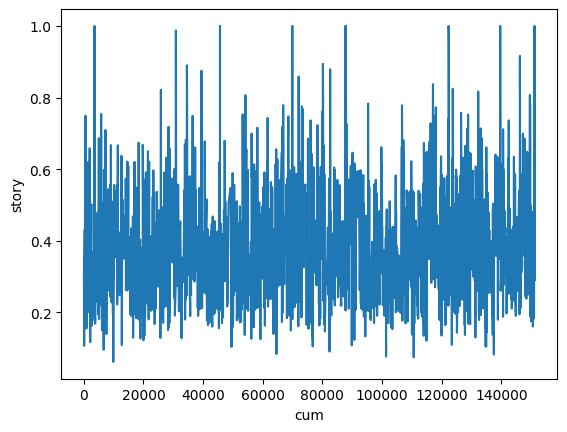

In [17]:
sns.lineplot(data=df, y='story', x='cum')

<AxesSubplot:xlabel='cum', ylabel='smooth'>

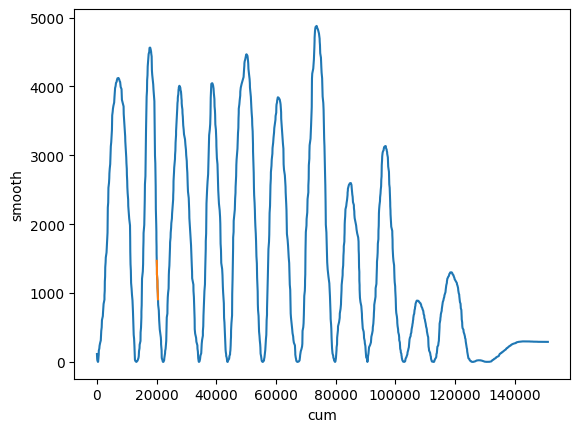

In [18]:
# Filter requirements.
T = 50.0         # Sample Period
fs = 20.0       # sample rate, Hz
cutoff = 3      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 10 * fs  # Nyquist Frequency
order = 10 # 6 # 10     # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

array = butter_lowpass_filter(story,cutoff, fs, order)
df['smooth'] = array
df['smooth'] = df['smooth'].apply(lambda x: round(round(x*100,2)**2,0))
sns.lineplot(data=df, y='smooth', x='cum')
sns.lineplot(data=df.loc[(df.cum>20000)&(df.cum<20500)], y='smooth', x='cum')

<AxesSubplot:xlabel='cum'>

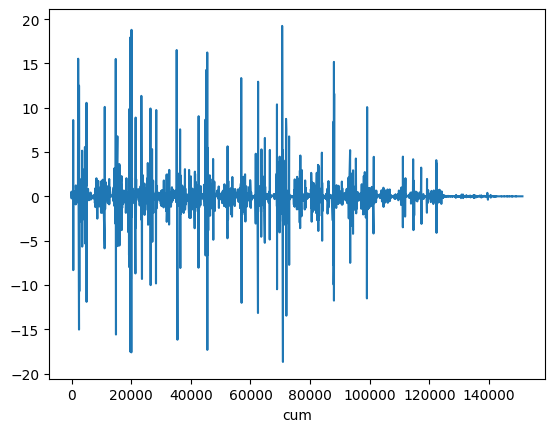

In [19]:
m =  np.diff(df['smooth'])/np.diff(df['cum'])
sns.lineplot(y=np.diff(m), x=df['cum'][:-2])

In [20]:
# import bayesian_changepoint_detection.offline_changepoint_detection as offcd
# from functools import partial
# data = df['smooth']
# Q, P, Pcp = offcd.offline_changepoint_detection(data, partial(offcd.const_prior, l=(len(data)+1)), offcd.gaussian_obs_log_likelihood, truncate=-1)
# fig, ax = plt.subplots(figsize=[18, 16])
# ax = fig.add_subplot(2, 1, 1)
# ax.plot(data[:])
# ax = fig.add_subplot(2, 1, 2, sharex=ax)
# ax.plot(np.exp(Pcp).sum(0))

In [21]:
max_num_states = 12

def build_latent_state(num_states, max_num_states, daily_change_prob=0.05):

  # Give probability exp(-100) ~= 0 to states outside of the current model.
  active_states_mask = tf.concat([tf.ones([num_states]),
                                  tf.zeros([max_num_states - num_states])],
                                 axis=0)
  initial_state_logits = -100. * (1 - active_states_mask)

  # Build a transition matrix that transitions only within the current
  # `num_states` states.
  transition_probs = tf.fill([num_states, num_states],
                             0. if num_states == 1
                             else daily_change_prob / (num_states - 1))  
  padded_transition_probs = tf.eye(max_num_states) + tf.pad(
      tf.linalg.set_diag(transition_probs,
                         tf.fill([num_states], - daily_change_prob)),
      paddings=[(0, max_num_states - num_states),
                (0, max_num_states - num_states)])

  return initial_state_logits, padded_transition_probs

# For each candidate model, build the initial state prior and transition matrix.
batch_initial_state_logits = []
batch_transition_probs = []
for num_states in range(1, max_num_states+1):
  initial_state_logits, transition_probs = build_latent_state(
      num_states=num_states,
      max_num_states=max_num_states)
  batch_initial_state_logits.append(initial_state_logits)
  batch_transition_probs.append(transition_probs)

batch_initial_state_logits = tf.stack(batch_initial_state_logits)
batch_transition_probs = tf.stack(batch_transition_probs)
print("Shape of initial_state_logits: {}".format(batch_initial_state_logits.shape))
print("Shape of transition probs: {}".format(batch_transition_probs.shape))
# print("Example initial state logits for num_states==3:\n{}".format(batch_initial_state_logits[2, :]))
# print("Example transition_probs for num_states==3:\n{}".format(batch_transition_probs[2, :, :]))

Shape of initial_state_logits: (12, 12)
Shape of transition probs: (12, 12, 12)


In [22]:
observed_counts = df['smooth'].astype('float32')

In [23]:
trainable_log_rates = tf.Variable(
    tf.fill([batch_initial_state_logits.shape[0], max_num_states],
            tf.math.log(tf.reduce_mean(observed_counts))) + 
     tf.random.stateless_normal([1, max_num_states], seed=(42, 42)),
     name='log_rates')

hmm = tfd.HiddenMarkovModel(
  initial_distribution=tfd.Categorical(
      logits=batch_initial_state_logits),
  transition_distribution=tfd.Categorical(probs=batch_transition_probs),
  observation_distribution=tfd.Poisson(log_rate=trainable_log_rates),
  num_steps=len(observed_counts))
print("Defined HMM with batch shape: {}".format(hmm.batch_shape))

Defined HMM with batch shape: (12,)


In [24]:
rate_prior = tfd.LogNormal(1, 1) #5,5

def log_prob():
  prior_lps = rate_prior.log_prob(tf.math.exp(trainable_log_rates))
  prior_lp = tf.stack(
      [tf.reduce_sum(prior_lps[i, :i+1]) for i in range(max_num_states)])
  return prior_lp + hmm.log_prob(observed_counts)

Text(0, 0.5, 'Negative log marginal likelihood')

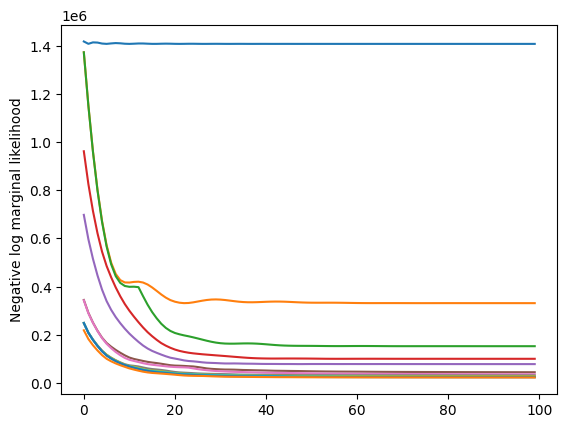

In [25]:
losses = tfp.math.minimize(
    lambda: -log_prob(),
    optimizer=tf.optimizers.Adam(0.1),
    num_steps=100)
plt.plot(losses)
plt.ylabel('Negative log marginal likelihood')

In [26]:
num_states = np.arange(1, max_num_states+1)
# plt.plot(num_states, -losses[-1])
# plt.ylim([-400, -200])
# plt.ylabel("marginal likelihood $\\tilde{p}(x)$")
# plt.xlabel("number of latent states")
# plt.title("Model selection on latent states")

In [27]:
rates = tf.exp(trainable_log_rates)
# for i, learned_model_rates in enumerate(rates):
#   print("rates for {}-state model: {}".format(i+1, learned_model_rates[:i+1]))

In [28]:
most_probable_states = hmm.posterior_mode(observed_counts)


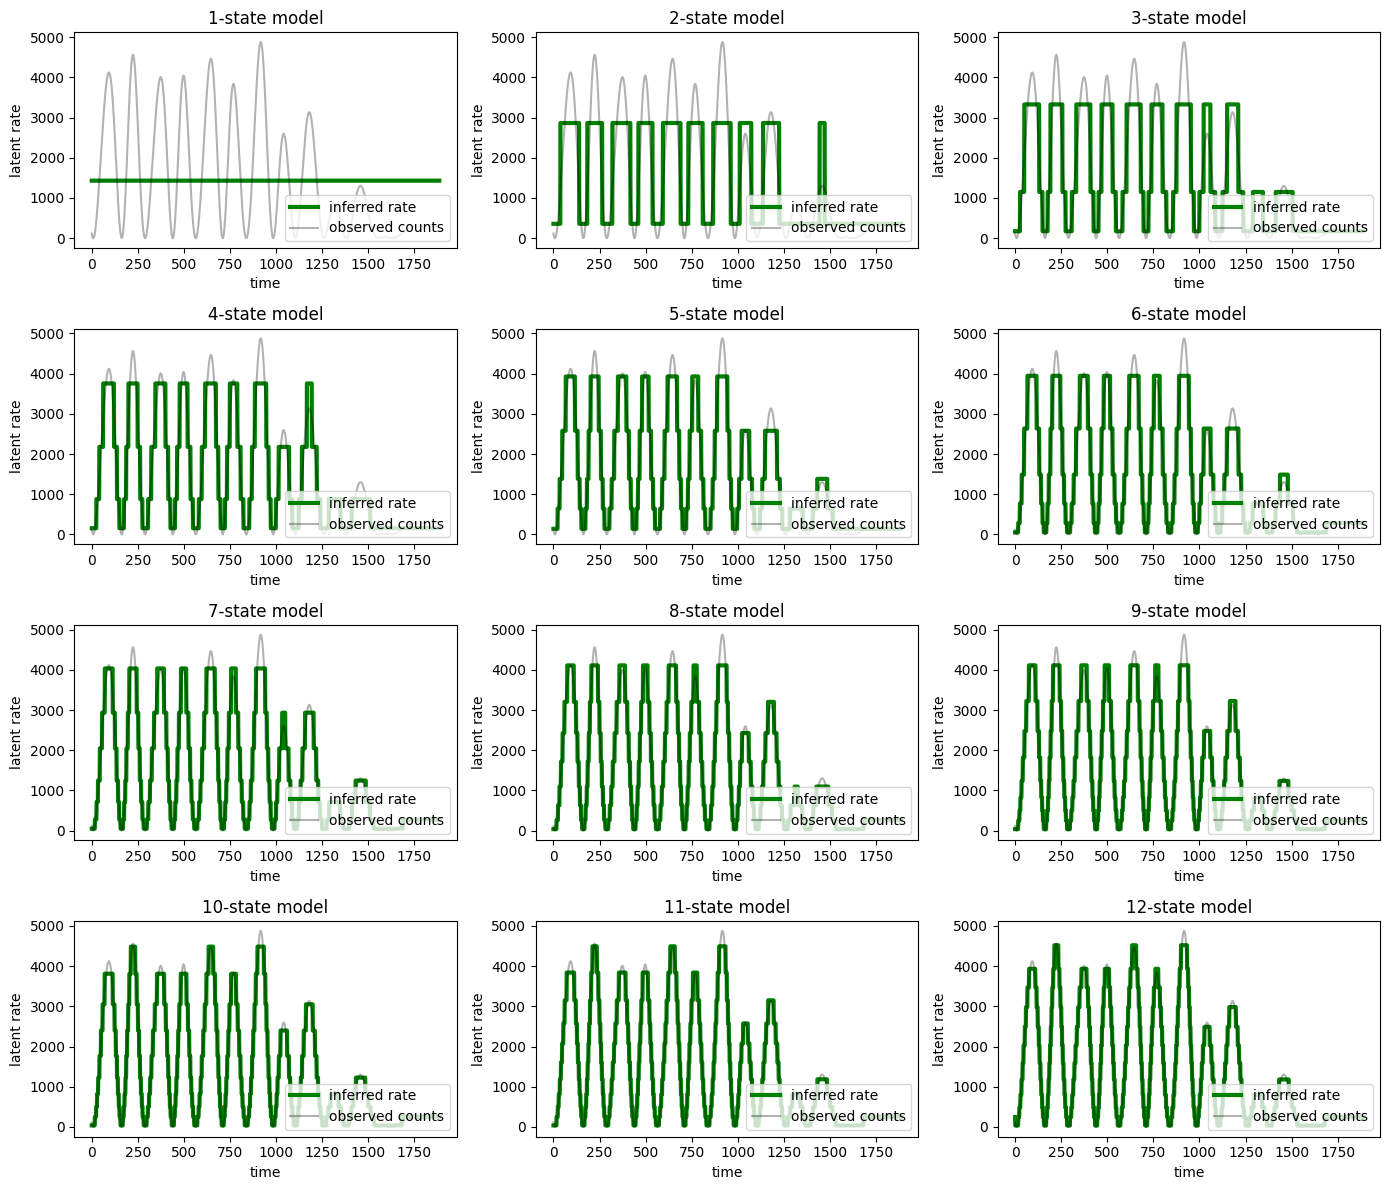

In [29]:
fig = plt.figure(figsize=(14, 12))
for i, learned_model_rates in enumerate(rates):
    
  ax = fig.add_subplot(4, 3, i+1)
  ax.plot(tf.gather(learned_model_rates, most_probable_states[i]), c='green', lw=3, label='inferred rate')
  ax.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
  ax.set_ylabel("latent rate")
  ax.set_xlabel("time")
  ax.set_title("{}-state model".format(i+1))
  ax.legend(loc=4)
plt.tight_layout()

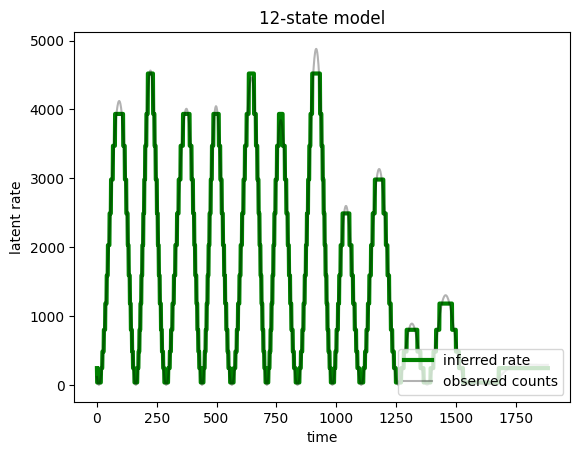

In [30]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
number = 11
ax.plot(tf.gather(learned_model_rates, most_probable_states[number]), c='green', lw=3, label='inferred rate')
ax.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
ax.set_ylabel("latent rate")
ax.set_xlabel("time")
ax.set_title("{}-state model".format(number+1))
ax.legend(loc=4)

In [33]:
df['bayes'] = tf.gather(learned_model_rates, most_probable_states[11])
time_diff = df[['cum']][df['bayes'] == df['bayes'].min()]
time_diff['diff_cum'] = time_diff['cum'].diff().fillna(0.0)

In [34]:
def is_outlier(x,mean,std):
    return int(np.abs(x - mean) > std)
    
    
#time_diff.drop(columns = ['index'] , inplace = True)
time_diff['outliers'] = time_diff['diff_cum'].apply(lambda x : is_outlier(x , time_diff['diff_cum'].mean() , time_diff['diff_cum'].std(ddof=0)))
total_categories = time_diff['outliers'].sum()
total_categories

11

[157, 282, 434, 557, 705, 831, 978, 1097, 1250, 1366, 1531]

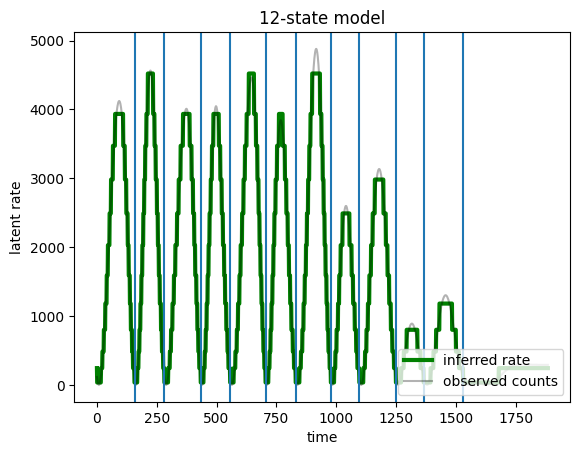

In [36]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
number = 11
ax.plot(tf.gather(learned_model_rates, most_probable_states[number]), c='green', lw=3, label='inferred rate')
ax.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
ax.set_ylabel("latent rate")
ax.set_xlabel("time")
ax.set_title("{}-state model".format(number+1))
ax.legend(loc=4)

outliers_loc = time_diff['cum'][time_diff['outliers']==1].index.tolist()

# for outlier in outliers_loc:
#     outliers_loc.append(outlier - 1)
    
for outlier in outliers_loc:
    ax.axvline(outlier)
    
outliers_loc

In [37]:
new_time_diff = time_diff.reset_index()

In [38]:
new_outliers_loc = [] 
max_iter = 1000

for idx , outlier in enumerate(outliers_loc):
    print(outlier)
    value = new_time_diff.iloc[new_time_diff[new_time_diff['index'] == outlier].index - 1]['index'].values[0]
    print(value)
    new_outliers_loc.append(value) 
    new_outliers_loc.append(outlier)
    if idx > max_iter:
        break

new_outliers_loc

157
16
282
168
434
297
557
445
705
571
831
716
978
846
1097
991
1250
1113
1366
1271
1531
1394


[16,
 157,
 168,
 282,
 297,
 434,
 445,
 557,
 571,
 705,
 716,
 831,
 846,
 978,
 991,
 1097,
 1113,
 1250,
 1271,
 1366,
 1394,
 1531]

[157, 282, 434, 557, 705, 831, 978, 1097, 1250, 1366, 1531]

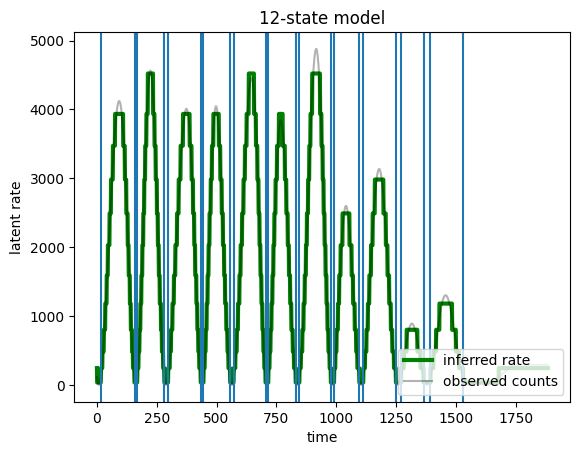

In [40]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
number = 11
ax.plot(tf.gather(learned_model_rates, most_probable_states[number]), c='green', lw=3, label='inferred rate')
ax.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
ax.set_ylabel("latent rate")
ax.set_xlabel("time")
ax.set_title("{}-state model".format(number+1))
ax.legend(loc=4)

outliers_loc = time_diff['cum'][time_diff['outliers']==1].index.tolist()

# for outlier in outliers_loc:
#     outliers_loc.append(outlier - 1)
    
for outlier in new_outliers_loc:
    ax.axvline(outlier)
    
outliers_loc

In [48]:
start_points = new_outliers_loc[::2]
middle_points = []
index_means = []

for start_point in start_points:
    end_point = new_outliers_loc[new_outliers_loc.index(start_point) + 1]
    print(f"Range : {start_point} , {end_point}")
    index_means.append( (end_point + start_point)/2)
    middle_points.append( time_diff.reset_index()[['cum','index']].query(f'{end_point} >= index >= {start_point}').median()[0] )

Range : 16 , 157
Range : 168 , 282
Range : 297 , 434
Range : 445 , 557
Range : 571 , 705
Range : 716 , 831
Range : 846 , 978
Range : 991 , 1097
Range : 1113 , 1250
Range : 1271 , 1366
Range : 1394 , 1531


[6641.0,
 17858.5,
 28360.5,
 39017.0,
 49720.0,
 61405.0,
 73665.0,
 85211.0,
 96518.0,
 107858.5,
 119065.5]

[157, 282, 434, 557, 705, 831, 978, 1097, 1250, 1366, 1531]

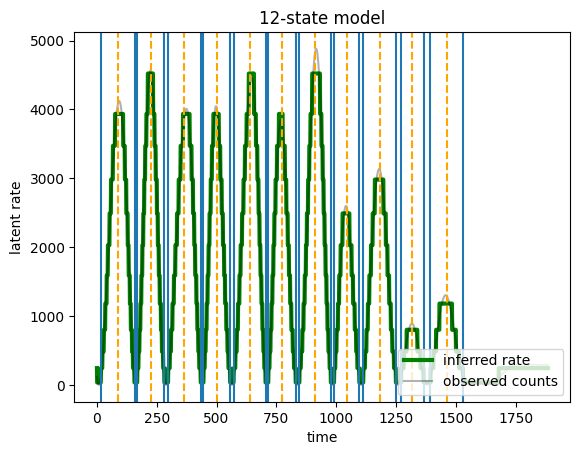

In [49]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
number = 11
ax.plot(tf.gather(learned_model_rates, most_probable_states[number]), c='green', lw=3, label='inferred rate')
ax.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
ax.set_ylabel("latent rate")
ax.set_xlabel("time")
ax.set_title("{}-state model".format(number+1))
ax.legend(loc=4)

outliers_loc = time_diff['cum'][time_diff['outliers']==1].index.tolist()

# for outlier in outliers_loc:
#     outliers_loc.append(outlier - 1)
    
for outlier in new_outliers_loc:
    ax.axvline(outlier)
    
for mean in index_means:
    ax.axvline(mean , color = 'orange' , linestyle = '--')
    
outliers_loc

In [44]:
# indexes = new_time_diff['index']
# middle_points = []



In [45]:
# time_diff['masked'] = time_diff['cum'].apply(lambda x: x - time_diff['cum'].std())
# time_diff['masked'] =time_diff['masked'].apply(lambda x: max(0,x))
# time_diff.plot()

# starts = []
# ends = []
# for each in range(len(time_diff)):
#     try:
#         if time_diff['masked'].iloc[each] < time_diff['masked'].iloc[each+1]:
#             print(each)
#             starts.append(each)
#         elif time_diff['masked'].iloc[each] > time_diff['masked'].iloc[each+1]:
#             print('end', each)

#     except:
#         print('Reached an end')
        
        

In [47]:
# df['new_bay'] = df['bayes'].apply(lambda x: min(df['bayes'].min()))

In [50]:
true_middle_points = [min(df['cum'], key=lambda x:abs(x-each-1000)) for each in middle_points]

text = ''
for num, each in enumerate(df['sentence']):
    if df['cum'].iloc[num] in true_middle_points:
        text+=f' \n \n  {each}. '
    else:
        text+=f'{each}. '
    
print(text)

Okay. You're very professional. People are like, how do you live.  And things like that. They're taking money from the russians. And of course the answer is no, but I do this for a living, like I speak. I don't have a YouTube channel where I'm joe rogan, but I give speeches at universities and things like that. I do a lot of interviews. We're recording now, right. My own setup. Is it possible that you could do a YouTube channel.  Would that work.  Yeah, if you introduce me so I get followers. Yeah, we could do that, dude, I'm all in. That could absolutely happen. Do you want to do that.  Is that something you want to do.  No. I mean, this is a big question. So I came on because I had just written a book called permanent record, which is the story of my life, because that's what publishers make you do when you're writing your first book. But it's more than that, because I didn't just want to talk about me. It's actually about the changing of technology and the changing of government in 

In [153]:
# text = ''
# for num, each in enumerate(df['sentence']):
#     if df['pcp'].iloc[num-5:num].mean() < df['pcp'].iloc[num:num+5].mean():
#         text+=f' \n \n  {each}. '
#     else:
#         text+=f'{each}. '
    
# print(text)

In [ ]:
df.head(1)

,story,sentence,len,cum,smooth,bayes,pcp
0,0.309211,Okay,4,4,33.55,34.938789,0.0


In [ ]:
df.loc[df.cum>43000]  

,story,sentence,len,cum,smooth,bayes,pcp
551,0.375309,"There's iraq, dictators, weapons of mass destr...",52,43022,36.0,34.938789,0.0
552,0.160076,They're holding the world at ransom,35,43057,36.0,34.938789,0.0
553,0.320594,You got colin powell at the UN,30,43087,36.0,34.938789,0.0
554,0.235474,"Dangling little vials of, like, fake anthrax",44,43131,36.0,34.938789,0.0
555,0.467870,"I felt an obligation to do my part, and so I v...",73,43204,36.0,34.938789,0.0
...,...,...,...,...,...,...,...
1881,0.596939,Open,4,151133,41.0,34.856045,0.0
1882,0.414088,Stay free,9,151142,41.0,34.856045,0.0
1883,0.289221,Open the possibility,20,151162,41.0,34.856045,0.0
1884,0.888815,Take care,9,151171,41.0,34.856045,0.0


In [ ]:
#20059, 40905

In [ ]:
text = ''
for num, each in enumerate(df['sentence']):
    if df['cum'].iloc[num] == 18964:
        text+=f' \n \n  \n \n \n \n {each}. '
    else:
        text+=f'{each}. '
    
print(text)

Okay. You're very professional. People are like, how do you live.  And things like that. They're taking money from the russians. And of course the answer is no, but I do this for a living, like I speak. I don't have a YouTube channel where I'm joe rogan, but I give speeches at universities and things like that. I do a lot of interviews. We're recording now, right. My own setup. Is it possible that you could do a YouTube channel.  Would that work.  Yeah, if you introduce me so I get followers. Yeah, we could do that, dude, I'm all in. That could absolutely happen. Do you want to do that.  Is that something you want to do.  No. I mean, this is a big question. So I came on because I had just written a book called permanent record, which is the story of my life, because that's what publishers make you do when you're writing your first book. But it's more than that, because I didn't just want to talk about me. It's actually about the changing of technology and the changing of government in 